# 假新聞分類與分析
- TF-IDF
- Word2Vec
- Sentence-BERT

In [8]:

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# 載入資料集
fake_df = pd.read_csv('./raw_data/fake.csv')
true_df = pd.read_csv('./raw_data/true.csv')

# 加上 label 欄位
fake_df['label'] = 1
true_df['label'] = 0

data = pd.concat([fake_df, true_df], ignore_index=True)
data = data[data['text'].notna()].reset_index(drop=True)

# 檢查各類別數量
print(data['label'].value_counts())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


label
1    23481
0    21417
Name: count, dtype: int64


In [9]:

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z ]', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return tokens

data['tokens'] = data['text'].astype(str).apply(preprocess)
data['clean_text'] = data['tokens'].apply(lambda x: ' '.join(x))
data.head(2)


,title,text,subject,date,label,tokens,clean_text
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,"[donald, trump, wish, american, happy, new, ye...",donald trump wish american happy new year leav...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,"[house, intelligence, committee, chairman, dev...",house intelligence committee chairman devin nu...


## TF-IDF + 分類器（SVM / Logistic Regression）

In [10]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(data['clean_text'], data['label'], test_size=0.2, random_state=42)

tfidf = TfidfVectorizer(max_features=5000)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

# 模型訓練與比較
classify_models = {
    "LinearSVC": LinearSVC(dual='auto'),
    "LogisticRegression": LogisticRegression(max_iter=1000)
}

for name, model in classify_models.items():
    model.fit(X_train_vec, y_train)
    preds = model.predict(X_test_vec)
    print(f"=== {name} ===")
    print(classification_report(y_test, preds))


=== LinearSVC ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4247
           1       1.00      0.99      1.00      4733

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

=== LogisticRegression ===
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4247
           1       0.99      0.99      0.99      4733

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



## SHAP 套件解釋

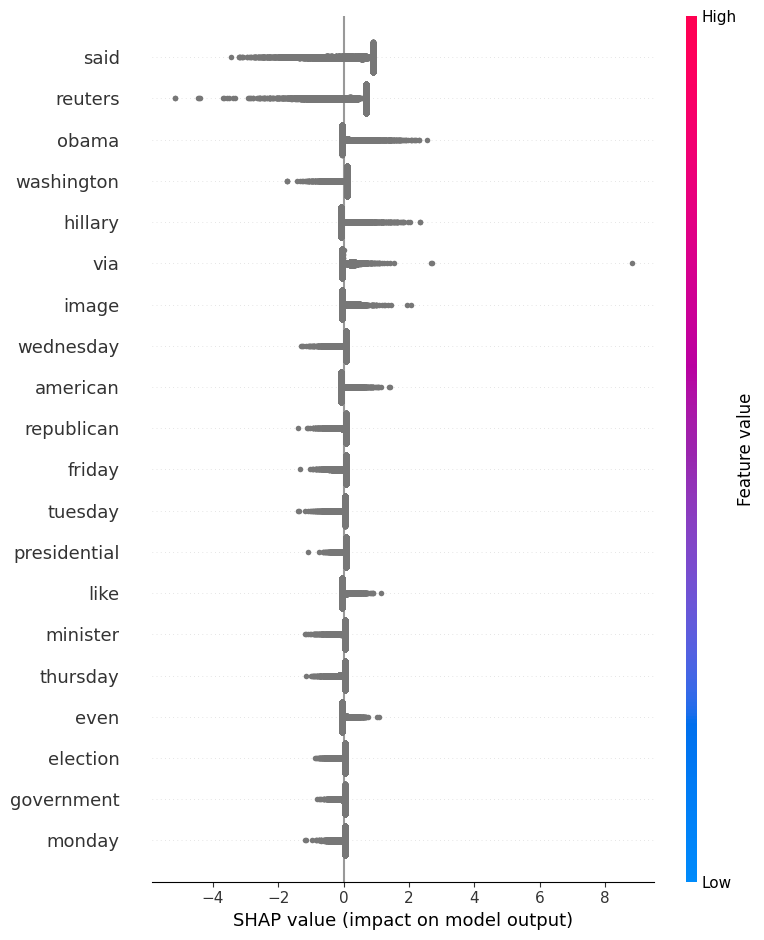

In [11]:
import shap
import matplotlib.pyplot as plt

explainer = shap.LinearExplainer(classify_models["LogisticRegression"], X_train_vec, feature_names=tfidf.get_feature_names_out())
# 計算整批 SHAP 值
shap_values = explainer(X_test_vec)
# 顯示整體 summary plot（橫向特徵影響）
shap.summary_plot(shap_values, X_test_vec, feature_names=tfidf.get_feature_names_out())


## Word2Vec

In [12]:

from gensim.models import Word2Vec

w2v_model = Word2Vec(sentences=data['tokens'], vector_size=100, window=5, min_count=2, workers=4)

def get_avg_w2v(tokens, model, k=100):
    vec = np.zeros(k)
    count = 0
    for word in tokens:
        if word in model.wv:
            vec += model.wv[word]
            count += 1
    return vec / count if count > 0 else vec

data['w2v_vec'] = data['tokens'].apply(lambda x: get_avg_w2v(x, w2v_model))

X = np.vstack(data['w2v_vec'].values)
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print(classification_report(y_test, preds))


              precision    recall  f1-score   support

           0       0.96      0.96      0.96      4247
           1       0.96      0.96      0.96      4733

    accuracy                           0.96      8980
   macro avg       0.96      0.96      0.96      8980
weighted avg       0.96      0.96      0.96      8980



## Sentence-BERT

In [13]:

from sentence_transformers import SentenceTransformer

# 模型可換成 'all-MiniLM-L6-v2', 'microsoft/Phi-4-mini-instruct' 等
model = SentenceTransformer('all-MiniLM-L6-v2')
data['sentence_emb'] = list(model.encode(data['text'].astype(str).tolist(), show_progress_bar=True))

X = np.vstack(data['sentence_emb'].values)
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print(classification_report(y_test, preds))


Batches:   0%|          | 0/1404 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      4247
           1       0.96      0.96      0.96      4733

    accuracy                           0.96      8980
   macro avg       0.96      0.96      0.96      8980
weighted avg       0.96      0.96      0.96      8980



In [ ]:
from matplotlib.font_manager import fontManager
fontManager.addfont('./public/TaipeiSansTCBeta-Regular.ttf')
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.rcParams['font.size'] = '16'

In [ ]:
from sklearn.cluster import KMeans
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline

# 載入英文NER模型和其對應的Tokenizer
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

# 建立pipeline方便處理
nlp = pipeline("ner", model=model, tokenizer=tokenizer)

ner_results = nlp(data['text'].astype(str).tolist()[:10])
ner_results